# CoCoScore Implementation

This notebook consists of implementing the [CoCoScore](https://www.biorxiv.org/content/10.1101/444398v1) literature model for comparison.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import pickle
import re
import sys

sys.path.append(os.path.abspath('../../../../modules'))

import operator
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, accuracy_score, confusion_matrix
from tqdm import tqdm_notebook

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.learning.pytorch.rnn.rnn_base import mark_sentence
from snorkel.learning.pytorch.rnn.utils import candidate_to_tokens
from snorkel.models import Candidate, candidate_subclass

from metal.analysis import lf_summary
from metal.label_model import LabelModel
from metal.utils import plusminus_to_categorical

from gensim.models import FastText
from gensim.models import KeyedVectors

from utils.notebook_utils.label_matrix_helper import label_candidates, get_auc_significant_stats
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes, generate_results_df
from utils.notebook_utils.plot_helper import plot_curve, plot_label_matrix_heatmap

In [4]:
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [5]:
quick_load = True

In [6]:
total_candidates_df = pd.read_table("../../dataset_statistics/data/all_dg_candidates_map.tsv.xz")
total_candidates_df.head(2)

,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.8586,1,0.0,1.0,3.0,2129459,The number of H antigen sites per single red c...,172,176680
1,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.8586,1,0.0,1.0,3.0,2129459,The number of H antigen sites per single red c...,172,176675


In [7]:
spreadsheet_names = {
    'train': '../../data/sentences/sentence_labels_train.xlsx',
    'dev': '../../data/sentences/sentence_labels_dev.xlsx',
    'test': '../../data/sentences/sentence_labels_test.xlsx'
}

In [8]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_dsh")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of train set: 300
Size of dev set: 1000
Size of test set: 1000


In [9]:
distant_supervision_marginals = pd.read_table("../../label_sampling_experiment/results/DaG/marginals/baseline_marginals.tsv.xz")
distant_supervision_marginals.head(2)

,pos_class_marginals,neg_class_marginals,candidate_id
0,0.013725,9.862746e-01,21422
1,0.999999,6.806644e-07,21427


In [10]:
all_embedded_dg_df = pd.read_table("../../word_vector_experiment/results/all_embedded_dg_sentences.tsv.xz")
all_embedded_dg_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,288,289,290,291,292,293,294,295,candidate_id,sen_length
0,28.0,2449.0,1.0,6.0,2550.0,1128.0,6.0,562.0,1.0,3871.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21421,43
1,6.0,3100.0,1.0,2.0,275.0,4.0,1362.0,200.0,201.0,8055.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21422,18


In [11]:
dev_df = pd.read_table("../../data/word_vectors/dev_dataframe.tsv.xz")
test_df = pd.read_table("../../data/word_vectors/test_dataframe.tsv.xz")

In [12]:
word_vectors = pd.read_csv(
    "../../word_vector_experiment/results/disease_associates_gene_word_vectors.bin",
    sep=" ", skiprows=1, 
    header=None, index_col=0, 
    keep_default_na=False
)
word_vectors.head(2)

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
",",0.022537,-0.033819,0.088639,0.098498,-0.088453,-0.019523,-0.111484,0.078027,-0.046744,0.123747,...,-0.149170,0.035198,0.175535,0.083895,0.026490,0.032788,0.092048,0.062732,-0.039812,0.003592
of,-0.056350,-0.019232,0.220481,0.135985,-0.108574,-0.067010,-0.119781,0.118084,0.098197,0.228681,...,0.048689,-0.047754,0.233640,0.159998,-0.186834,0.077585,0.063618,-0.051798,-0.000775,0.000644


In [13]:
word_dict = pd.read_table("../../word_vector_experiment/results/disease_associates_gene_word_dict.tsv", keep_default_na=False)
reverse_word_dict = dict(zip(word_dict.index, word_dict.word))
word_dict = dict(zip(word_dict.word, word_dict.index))

In [14]:
total_training_sentences_df = (
    all_embedded_dg_df.merge(
        distant_supervision_marginals
        .assign(labels=lambda x: x.pos_class_marginals > 0.5)
        [["labels", "candidate_id"]]
        .astype({"labels":int}),
        on="candidate_id"
    )
)
total_training_sentences_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,289,290,291,292,293,294,295,candidate_id,sen_length,labels
0,6.0,3100.0,1.0,2.0,275.0,4.0,1362.0,200.0,201.0,8055.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21422,18,0
1,6.0,1193.0,2513.0,1.0,1.0,97.0,1.0,98.0,171.0,573.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21427,22,1


In [15]:
total_dev_sentences_df = (
    dev_df.merge(
        candidate_dfs['dev']
        [["curated_dsh", "candidate_id"]],
        on="candidate_id"
    )
)
total_dev_sentences_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,185,186,187,188,189,190,191,candidate_id,sen_length,curated_dsh
0,9,529,2,2963,72,26,9,14475,436,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21841,63,1.0
1,15,36,21,2051,10,8,1,12,394,32771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82680,72,0.0


In [16]:
total_test_sentences_df = (
    test_df.merge(
        candidate_dfs['test']
        [["curated_dsh", "candidate_id"]],
        on="candidate_id"
    )
)
total_test_sentences_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,candidate_id,sen_length,curated_dsh
0,3914,192,8,15,10719,10,7465,1016,142,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23356,50,0.0
1,9,584,20,3,22521,4,28,66,94,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23367,22,1.0


In [17]:
def create_data_matrix(query_df, filename="sentences.txt"):
    search_regex = rf'(\b{word_dict["~~[[2"]}\b.+\b{word_dict["2]]~~"]}\b,)'
    search_regex += rf'|(\b{word_dict["~~[[1"]}\b.+\b{word_dict["1]]~~"]}\b,)'
    
    print(search_regex)
    data = []
    with open(filename, "w") as g:
        for index, row in tqdm_notebook(query_df.iterrows()):
            cand_str = ",".join(map(str, row.dropna().astype(int).values))
            pruned_str = re.sub(search_regex, "", cand_str)
            values = list(map(int, pruned_str.split(",")))
            g.write(f"__label__{values[-1]}\t")
            g.write("\t".join([reverse_word_dict[val] for val in values[:-2]]))
            g.write("\n")

In [18]:
query_df = (
    total_training_sentences_df
    [[col for col in total_training_sentences_df.columns if col not in ["sen_length"]]]
)
training_matrix = create_data_matrix(query_df, filename="training.txt")

(\b2\b.+\b4\b,)|(\b22\b.+\b25\b,)


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [19]:
query_df = (
    total_dev_sentences_df
    [[col for col in total_dev_sentences_df.columns if col not in ["sen_length"]]]
)
dev_matrix = create_data_matrix(query_df, filename="dev.txt")

(\b2\b.+\b4\b,)|(\b22\b.+\b25\b,)


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [20]:
query_df = (
    total_test_sentences_df
    [[col for col in total_test_sentences_df.columns if col not in ["sen_length"]]]
)
test_matrix = create_data_matrix(query_df, filename="test.txt")

(\b2\b.+\b4\b,)|(\b22\b.+\b25\b,)


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [21]:
os.system("../../../../../fastText/fasttext supervised -input training.txt -output dag_model -lr 0.005 -epoch 50 -dim 300 -wordNgrams 2")
os.system("../../../../../fastText/fasttext predict-prob dag_model.bin dev.txt > dev_predictions.tsv")
os.system("../../../../../fastText/fasttext predict-prob dag_model.bin test.txt > test_predictions.tsv")

0

In [22]:
precision, recall, _ = precision_recall_curve(
    total_dev_sentences_df.curated_dsh,
    pd.read_table('dev_predictions.tsv', header=None, sep=" ")[1]
)
auc(recall, precision)

0.39463732004228247

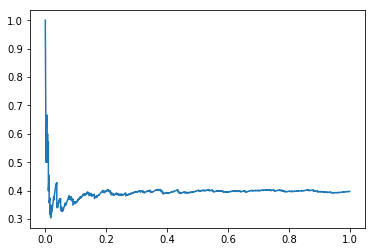

In [23]:
plt.plot(recall, precision)

In [24]:
fpr, tpr, _ = roc_curve(
    total_dev_sentences_df.curated_dsh,
    pd.read_table('dev_predictions.tsv', header=None, sep=" ")[1]
)
auc(fpr, tpr)

0.49953005752095947

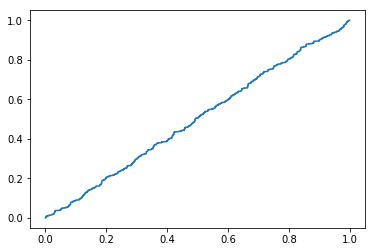

In [25]:
plt.plot(fpr, tpr)

In [27]:
query_df = (
    all_embedded_dg_df
    .assign(labels=0)
    [[col for col in all_embedded_dg_df.columns if col not in ["sen_length"]]]
)
create_data_matrix(query_df, filename="all_dg_sentences.txt")

(\b2\b.+\b4\b,)|(\b22\b.+\b25\b,)


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [28]:
os.system("../../../../../fastText/fasttext predict-prob dag_model.bin all_dg_sentences.txt > all_dg_sentences_predictions.tsv")

0

In [34]:
predictions_df = pd.read_table("all_dg_sentences_predictions.tsv", header=None, names=["label", "predictions"], sep=" ")
predictions_df['candidate_id'] = all_embedded_dg_df.candidate_id.values
predictions_df.head(2)

,label,predictions,candidate_id
0,__label__1,0.504584,21421
1,__label__0,0.656317,21422


In [38]:
final_pred_df = (
    total_candidates_df
    [["doid_id", "entrez_gene_id", "candidate_id"]]
    .merge(predictions_df[["predictions", "candidate_id"]])
)
final_pred_df.head(2)

,doid_id,entrez_gene_id,candidate_id,predictions
0,DOID:2531,1,176680,0.531630
1,DOID:2531,1,176675,0.527441


In [76]:
added_scores_df = (
    final_pred_df
    .groupby(["doid_id", "entrez_gene_id"])
    .aggregate({"predictions": 'sum'})
    .reset_index()
)
added_scores_df.head(2)

,doid_id,entrez_gene_id,predictions
0,DOID:0050156,2,1.956440
1,DOID:0050156,16,2.355204


In [77]:
total_score = added_scores_df.predictions.sum()
disease_scores = added_scores_df.groupby("doid_id").agg({"predictions":"sum"}).reset_index()
disease_scores = dict(zip(disease_scores.doid_id, disease_scores.predictions))
gene_scores = added_scores_df.groupby("entrez_gene_id").agg({"predictions":"sum"}).reset_index()
gene_scores = dict(zip(gene_scores.entrez_gene_id, gene_scores.predictions))

alpha=0.65

final_scores_df = added_scores_df.assign(
    final_score=(
        added_scores_df.apply(
            lambda x: pd.np.exp(
                    alpha*pd.np.log(x['predictions']) + (1-alpha)*(
                    pd.np.log(x['predictions']) + pd.np.log(total_score) - 
                    pd.np.log(disease_scores[x['doid_id']]) - pd.np.log(gene_scores[x['entrez_gene_id']])
                )
            ), 
            axis=1
        )
    )
)
final_scores_df.head(2)

,doid_id,entrez_gene_id,predictions,final_score
0,DOID:0050156,2,1.956440,1.351489
1,DOID:0050156,16,2.355204,11.518866


In [79]:
score_with_labels_df = (
    final_scores_df
    .merge(
        total_candidates_df[["entrez_gene_id", "doid_id", "hetionet"]],
        on=["entrez_gene_id", "doid_id"]
    )
    .drop_duplicates()
)
score_with_labels_df.head(2)

,doid_id,entrez_gene_id,predictions,final_score,hetionet
0,DOID:0050156,2,1.956440,1.351489,0
2,DOID:0050156,16,2.355204,11.518866,0


In [84]:
score_with_labels_df.drop("predictions", axis=1).to_csv("dg_edge_prediction_cocoscore.tsv", sep="\t", index=False)

In [82]:
fpr, tpr, _ = roc_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(fpr, tpr))

precision, recall, _ = precision_recall_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(recall, precision))

0.8105025858301396
0.426268192647387
